# Decision Trees y Random Forests

Random forests en un ejemplo de un método de *ensamblaje*, lo que significa que se basa en agregar los resultados de un ensamblaje de estimadores simples. El resultado es sorprendente porque para este tipo de métodos la suma puede ser más grande que sus partes: una decisión tomada por un número de estimadores puede ser mejor que cualquiera de las decisiones tomadas por medio de esos estimadores individuales.
Comenzamos con los import típicos:

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Motivación de Random Forests: Decision Trees

Random forests es un ejemplo de un *modelo de ensamblaje* construido sobre decision trees.
Por lo mismo, comenzaremos conociendo que un Árbol de Decisión.

Los Árboles de Decision son una manera extremadamente intituitiva de clasificar objetos: simplemente se hacen una serie de preguntas diseñadas para ir construyendo de forma escalonada la clasficación.  Por ejemplo, si quisieramos construir un árbol de decisión para clasificar un animal que nos encontremos en un paseo en un cerro, podríamos construir algo como esto:

![](figures/05.08-decision-tree.png)

La división binaria hace que esto sea extremadamente eficiente: en un árbol bien construido, cada pregunta reducirá la cantidad de opciones a aproximadamente la mitad, reduciendo muy rápidamente las opciones incluso entre una gran cantidad de clases.
El truco, por supuesto, está en decidir qué preguntas hacer en cada paso.
En las implementaciones de machine learning de árboles de decisión, las preguntas generalmente toman la forma de divisiones alineadas con el eje en los datos: es decir, cada nodo en el árbol divide los datos en dos grupos usando un valor de corte dentro de una de las características.
Veamos ahora un ejemplo de esto.

### Creando un decision tree

Considere los siguientes datos bidimensionales, que tienen una de cuatro etiquetas de clase:

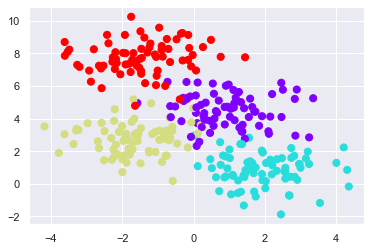

In [3]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

Un árbol de decisión simple construido sobre estos datos dividirá iterativamente los datos a lo largo de uno u otro eje de acuerdo con algún criterio cuantitativo, y en cada nivel asignará la etiqueta de la nueva región de acuerdo con el voto mayoritario de los puntos dentro de ella.
La siguiente figura presenta una visualización de los primeros cuatro niveles de un clasificador de árbol de decisión para estos datos:

![](figures/05.08-decision-tree-levels.png)

Tengamos en cuenta que después de la primera división, todos los puntos de la rama superior permanecen sin cambios, por lo que no es necesario subdividir más esa rama.
A excepción de los nodos que contienen todo de un color, en cada nivel *todas* las regiones se dividen nuevamente a lo largo de una de las dos características.

Este proceso de ajustar un árbol de decisión a nuestros datos se puede hacer en Scikit-Learn con el estimador ``DecisionTreeClassifier``:

In [4]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

Escribamos una función rápida para ayudarnos a visualizar la salida del clasificador:

In [7]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

Ahora podemos examinar cómo se ve la clasificación realizada por el árbol de decisión:

C:\Users\Alonso\AppData\Local\Temp\ipykernel_4836\520376207.py:20: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


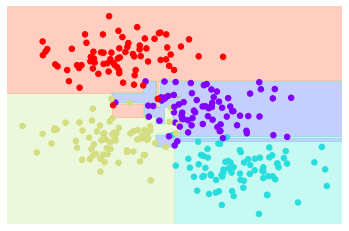

In [6]:
visualize_classifier(DecisionTreeClassifier(), X, y)

Y si revisamos paso a paso en la profundidad:

C:\Users\Alonso\AppData\Local\Temp\ipykernel_4836\520376207.py:20: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


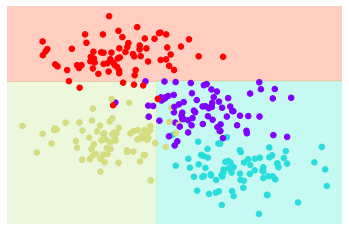

In [9]:
visualize_classifier(DecisionTreeClassifier(max_depth=2), X, y)

C:\Users\Alonso\AppData\Local\Temp\ipykernel_4836\520376207.py:20: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


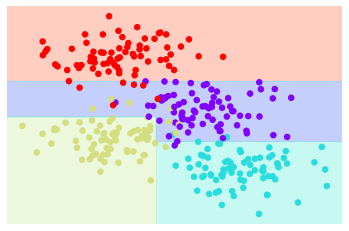

In [10]:
visualize_classifier(DecisionTreeClassifier(max_depth=3), X, y)

C:\Users\Alonso\AppData\Local\Temp\ipykernel_4836\520376207.py:20: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


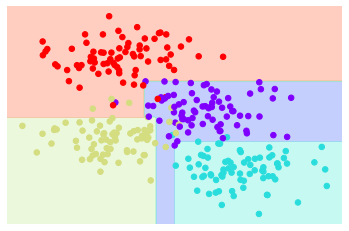

In [11]:
visualize_classifier(DecisionTreeClassifier(max_depth=4), X, y)

C:\Users\Alonso\AppData\Local\Temp\ipykernel_4836\520376207.py:20: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


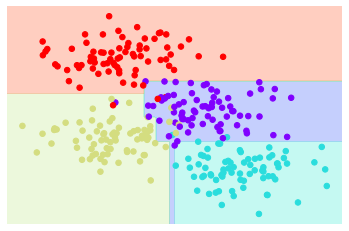

In [12]:
visualize_classifier(DecisionTreeClassifier(max_depth=5), X, y)

Notemos que a medida que aumenta la profundidad, tendemos a obtener regiones de clasificación de formas muy extrañas; por ejemplo, a una profundidad de cinco, hay una región morada alta y delgada entre las regiones amarilla y verde.
Está claro que esto no corresponde tanto a la verdadera distribución de datos intrínseca y responde más el resultado de las propiedades particulares de muestreo o ruido de los datos.
Es decir, este árbol de decisiones, incluso con solo cinco niveles de profundidad, está claramente sobreajustado a nuestros datos.

### Decision trees y over-fitting

Tal ajuste excesivo resulta ser una propiedad general de los árboles de decisión: es muy fácil profundizar demasiado en el árbol y, por lo tanto, ajustar los detalles de los datos particulares en lugar de las propiedades generales de las distribuciones de los que se extraen.
Otra forma de ver este sobreajuste es mirar modelos entrenados en diferentes subconjuntos de datos; por ejemplo, en esta figura entrenamos dos árboles diferentes, cada uno con la mitad de los datos originales:

![](figures/05.08-decision-tree-overfitting.png)

Está claro que en algunos lugares los dos árboles producen resultados consistentes (por ejemplo: en las cuatro esquinas), mientras que en otros lugares los dos árboles dan clasificaciones muy diferentes (por ejemplo en las regiones entre dos grupos).
La observación clave es que las inconsistencias tienden a ocurrir donde la clasificación es menos segura y, por lo tanto, al usar información de *ambos* árboles, ¡podríamos obtener un mejor resultado!

## Ensamblaje de Estimadores: Random Forests

Esta noción de que múltiples estimadores de sobreajuste pueden combinarse para reducir el efecto de este sobreajuste, es lo que se consigue con un método de ensamblaje llamado *bagging*.
El  bagging utiliza un conjunto de estimadores en paralelo, cada uno de los cuales sobreajusta los datos, y promedia los resultados para encontrar una mejor clasificación.
Un conjunto de árboles de decisión aleatorios se conoce como *bosque aleatorio* o *random forest*.

Este tipo de clasificación de baggging se puede realizar manualmente utilizando el metaestimador ``BaggingClassifier`` de Scikit-Learn, como se muestra aquí:

C:\Users\Alonso\AppData\Local\Temp\ipykernel_4836\520376207.py:20: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


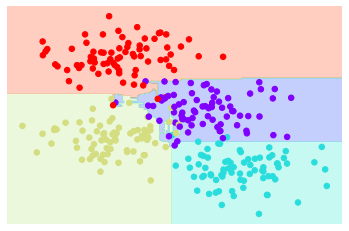

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

En este ejemplo, hemos aleatorizado los datos ajustando cada estimador con un subconjunto aleatorio del 80 % de los puntos de entrenamiento.
En la práctica, los árboles de decisión se aleatorizan de manera más efectiva al inyectar algo de estocasticidad en la forma en que se eligen las divisiones: de esta manera, todos los datos contribuyen al ajuste cada vez, pero los resultados del ajuste aún tienen la aleatoriedad deseada.
Por ejemplo, al determinar qué característica dividir, el árbol aleatorio puede seleccionar entre las principales características.
Puede leer más detalles técnicos sobre estas estrategias de aleatorización en la [documentación de Scikit-Learn](http://scikit-learn.org/stable/modules/ensemble.html#forest).

En Scikit-Learn, este conjunto optimizado de árboles de decisión aleatorios se implementa en el estimador ``RandomForestClassifier``, que se encarga de toda la aleatorización automáticamente.
Todo lo que necesita hacer es seleccionar una cantidad de estimadores, y muy rápidamente se ajustará al conjunto de árboles:

C:\Users\Alonso\AppData\Local\Temp\ipykernel_4836\520376207.py:20: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


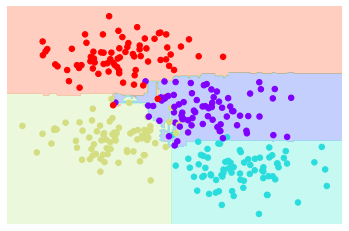

In [16]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
visualize_classifier(model, X, y);

Vemos entonces que al promediar más de 100 modelos perturbados aleatoriamente, terminamos con un modelo general que está mucho más cerca de nuestra intuición sobre cómo se debe dividir el espacio de parámetros.

## Regresión usando Random Forest

Hasta ahora hemos onsiderado los bosques aleatorios dentro del contexto de la clasificación.
También se puede hacer que los bosques aleatorios funcionen en el caso de regresión (es decir, variables continuas en lugar de categóricas). El estimador a usar para esto es ``RandomForestRegressor``, y la sintaxis es muy similar a la que vimos antes.

Considere los siguientes datos, construidos buscando la combinación de una oscilación rápida y lenta:

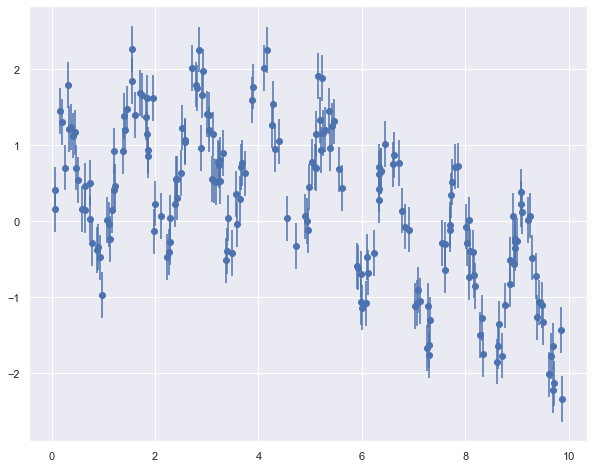

In [21]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)
fig, ax = plt.subplots(figsize=(10, 8))

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

Usando el regresor de bosque aleatorio, podemos encontrar la curva de mejor ajuste de la siguiente manera:

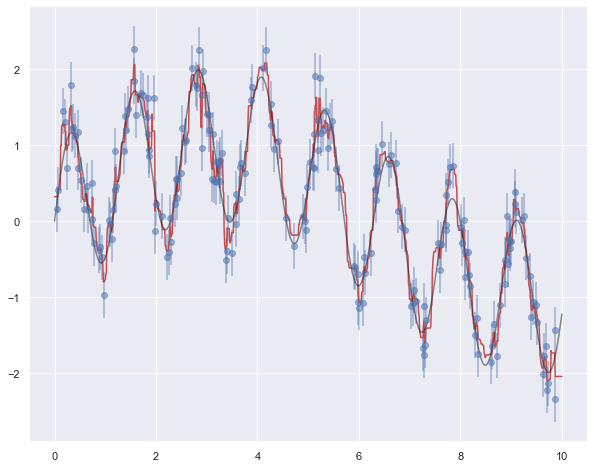

In [20]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

fig, ax = plt.subplots(figsize=(10, 8))
plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Aquí, el modelo real se muestra en la curva gris uniforme, mientras que el modelo de bosque aleatorio se muestra en la curva roja irregular.
Como puede ver, el modelo de bosque aleatorio no paramétrico es lo suficientemente flexible como para adaptarse a los datos de varios períodos, ¡sin que tengamos que especificar un modelo de varios períodos!

## Ejemplo: Random Forest para clasificar dígitos

Anteriormente echamos un vistazo rápido a los datos de dígitos escritos a mano.
Usemos eso nuevamente aquí para ver cómo se puede usar el clasificador de bosque aleatorio en este contexto.

In [22]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

Para recordarnos de que se tratan estos datos, visualizaremos los primeros puntos:

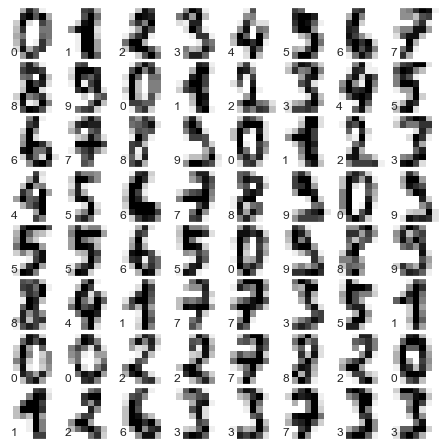

In [23]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

Podemos clasificar rápidamente los dígitos usando un random forest de la siguiente manera:

In [25]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

Podemos echar un vistazo al informe de clasificación de este clasificador:

In [26]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       1.00      0.98      0.99        44
           2       0.95      1.00      0.98        42
           3       0.98      0.96      0.97        46
           4       0.97      1.00      0.99        37
           5       0.98      0.98      0.98        48
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



Y miremos la matriz de confusión:

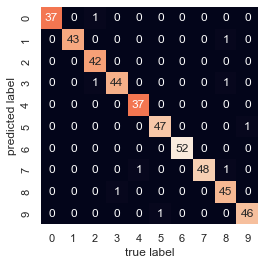

In [33]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

Encontramos que un bosque aleatorio simple y sin ajustar aun los parámetros da como resultado una clasificación muy precisa de los datos de dígitos.

# Ejemplo usando datos de Iris

In [36]:
from sklearn.datasets import load_iris

In [43]:
iris = load_iris()
Xtrain, Xtest, ytrain, ytest = train_test_split(iris.data, iris.target,
                                                random_state=0)
model_dt = DecisionTreeClassifier()
model_dt.fit(Xtrain, ytrain)
ypred = model_dt.predict(Xtest)

In [44]:
model_dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

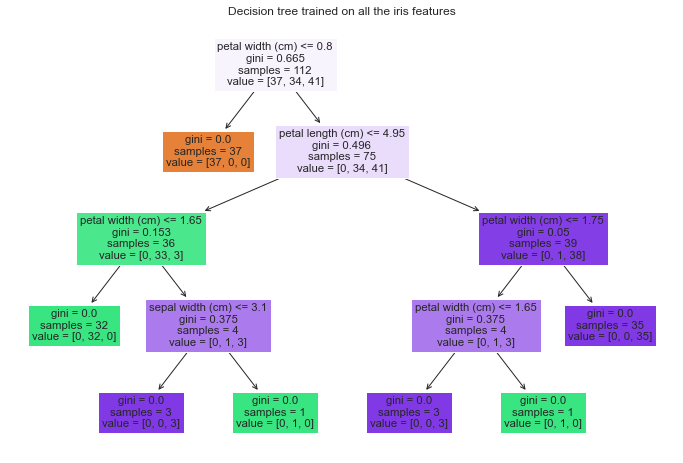

In [58]:
from sklearn.tree import plot_tree

plt.figure(figsize=(12,8)) #(12,6)

plot_tree(model_dt, filled=True, feature_names=iris.feature_names)
plt.title("Decision tree trained on all the iris features")
plt.show()

In [46]:
model_rf = RandomForestClassifier(n_estimators=1000)
model_rf.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [55]:
importances = model_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_], axis=0)


In [56]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

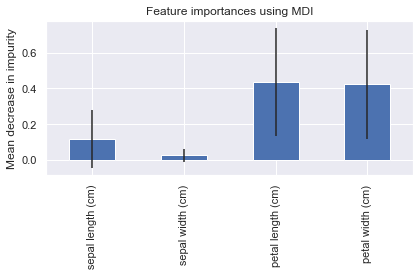

In [57]:
forest_importances = pd.Series(importances, index=iris.feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()